In [164]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# Importing Data

In [4]:
df = pd.read_csv('daily-website-visitors.csv', index_col='Date', parse_dates=True)

In [45]:
df.head(10)

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,2146.0,1582.0,1430.0,152.0
2014-09-15,2,Monday,2,3621.0,2528.0,2297.0,231.0
2014-09-16,3,Tuesday,3,3698.0,2630.0,2352.0,278.0
2014-09-17,4,Wednesday,4,3667.0,2614.0,2327.0,287.0
2014-09-18,5,Thursday,5,3316.0,2366.0,2130.0,236.0
2014-09-19,6,Friday,6,2815.0,1863.0,1622.0,241.0
2014-09-20,7,Saturday,7,1658.0,1118.0,985.0,133.0
2014-09-21,8,Sunday,1,2288.0,1656.0,1481.0,175.0
2014-09-22,9,Monday,2,3638.0,2586.0,2312.0,274.0


In [42]:
df.index.freq='D'

# Because there was a problem with plotting data, it's necessary to transform values in some columns

In [27]:
df['Page.Loads']=df['Page.Loads'].apply(lambda x : float(x.replace(',','')))
df['Unique.Visits']=df['Unique.Visits'].apply(lambda x : float(x.replace(',','')))
df['First.Time.Visits']=df['First.Time.Visits'].apply(lambda x : float(x.replace(',','')))
df['Returning.Visits']=df['Returning.Visits'].apply(lambda x : float(x.replace(',','')))

<AxesSubplot:xlabel='Date'>

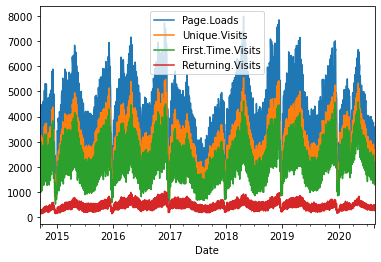

In [29]:
df[['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']].plot()

# We are interest only in column 'First.Time.Visitors', so let's make it as new DataFrame

<AxesSubplot:xlabel='Date'>

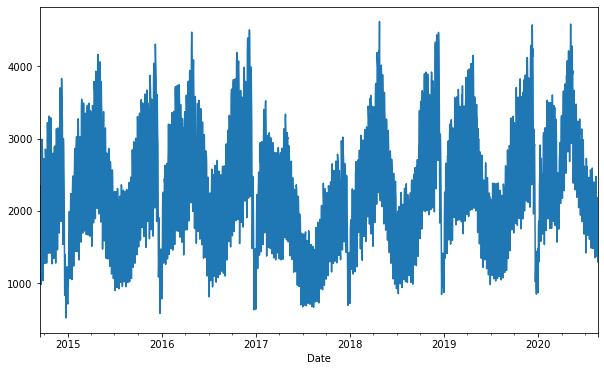

In [170]:
df1 = df['First.Time.Visits']
df1.plot(figsize=(10,6))

# This column looks like it might be stationary, so I will use adfuller to check if I'm right

In [171]:
from statsmodels.tsa.stattools import adfuller

In [172]:
adfuller(df1)

(-4.478689227918484,
 0.00021482988651450657,
 26,
 2140,
 {'1%': -3.4334094211542983,
  '5%': -2.8628915360971003,
  '10%': -2.5674894918770197},
 28745.700990077945)

# From the tests I can se that data is stationary. Let's check how it will look in seasonal_decompose

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

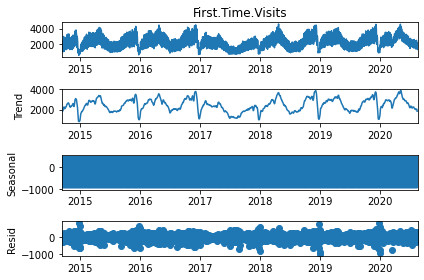

In [43]:
seasonalDecomposition = seasonal_decompose(df1)
seasonalDecomposition.plot();

# We can see that there exist somekind of yearly trend, but we should check for daily

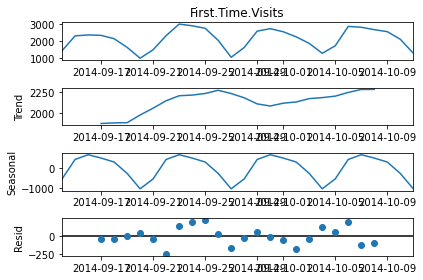

In [178]:
df2 = df1[:28]
seasonalDecomposition = seasonal_decompose(df2)
seasonalDecomposition.plot();

# For first 4 weeks exist seasonal trend, but let's check is it like this for whole length of data

In [186]:
df_gb = df.groupby(by='Day.Of.Week').mean()['First.Time.Visits']

<AxesSubplot:xlabel='Day.Of.Week'>

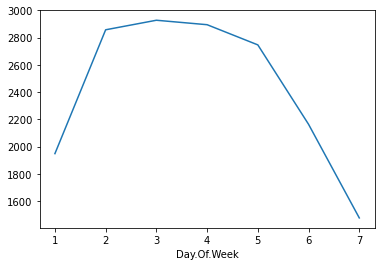

In [187]:
df_gb.plot()

# We can see that this trend remain in whole dataset. Now it's time to do some predictions for our data. Let's start with AutoReg model

In [51]:
from statsmodels.tsa.ar_model import AR, ARResults, AutoReg

# But first lets split data into training ad testing sets. Test set will contain 30 (last) values.

In [55]:
train = df1[:-30]
test = df1[-30:]

In [61]:
ar = AutoReg(train, lags=1)
ar_fit = ar.fit();

In [68]:
start = len(train)
end = len(train) + len(test) - 1
predictionsAR = ar_fit.predict(start=start, end=end, dynamic=False).rename('AutoReg Predictions')

In [73]:
predictionsAR

2020-07-21    2430.488680
2020-07-22    2432.404013
2020-07-23    2433.878087
2020-07-24    2435.012561
2020-07-25    2435.885673
2020-07-26    2436.557635
2020-07-27    2437.074790
2020-07-28    2437.472801
2020-07-29    2437.779118
2020-07-30    2438.014864
2020-07-31    2438.196299
2020-08-01    2438.335935
2020-08-02    2438.443401
2020-08-03    2438.526109
2020-08-04    2438.589762
2020-08-05    2438.638751
2020-08-06    2438.676454
2020-08-07    2438.705470
2020-08-08    2438.727802
2020-08-09    2438.744989
2020-08-10    2438.758216
2020-08-11    2438.768396
2020-08-12    2438.776231
2020-08-13    2438.782261
2020-08-14    2438.786901
2020-08-15    2438.790473
2020-08-16    2438.793222
2020-08-17    2438.795337
2020-08-18    2438.796965
2020-08-19    2438.798218
Freq: D, Name: AutoReg Predictions, dtype: float64

<AxesSubplot:xlabel='Date'>

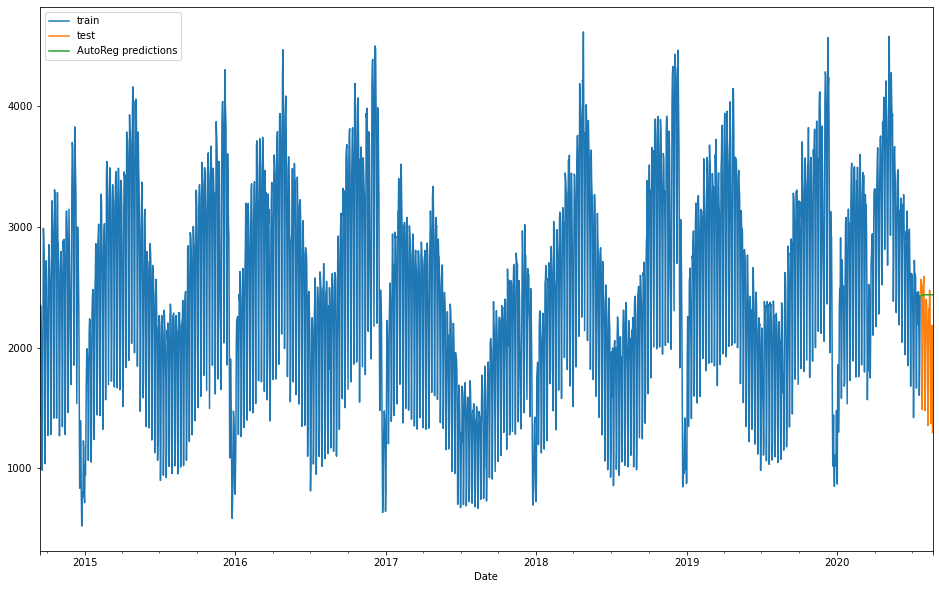

In [189]:
train.plot(legend=True, label='train', figsize=(16,10))
test.plot(legend=True, label='test')
predictionsAR.plot(legend=True, label='AutoReg predictions')

<AxesSubplot:xlabel='Date'>

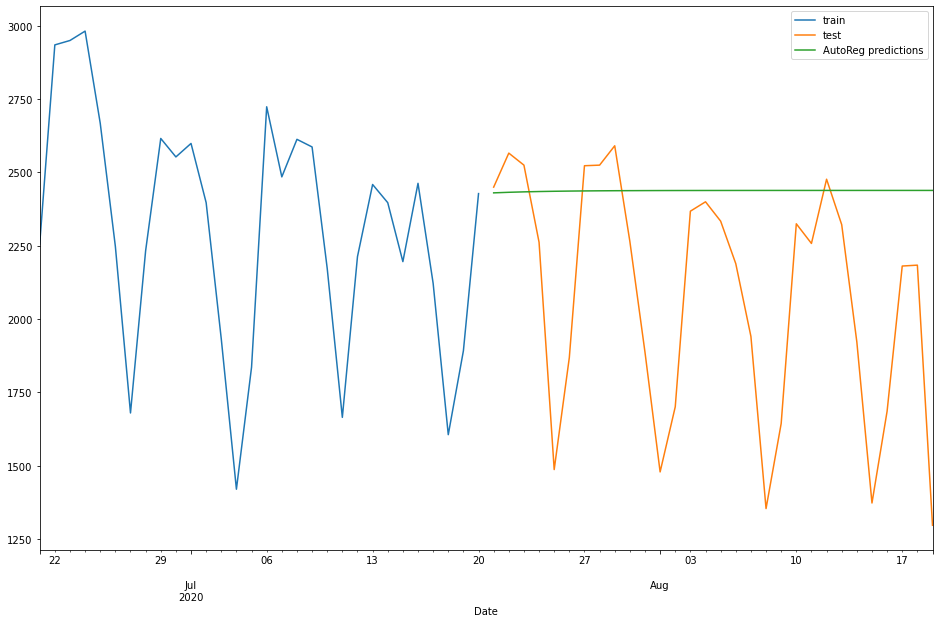

In [190]:
train[-30:].plot(legend=True, label='train', figsize=(16,10))
test.plot(legend=True, label='test')
predictionsAR.plot(legend=True, label='AutoReg predictions')

# Predictions doesn't look, but let's check the error

In [76]:
mean_absolute_percentage_error(test, predictionsAR)

0.24133904461133693

# Error is quite big, but that's something I expected due to seasonality of the data. Let's try different models and first will be Holt-Winters

In [79]:
from statsmodels.tsa.api import ExponentialSmoothing

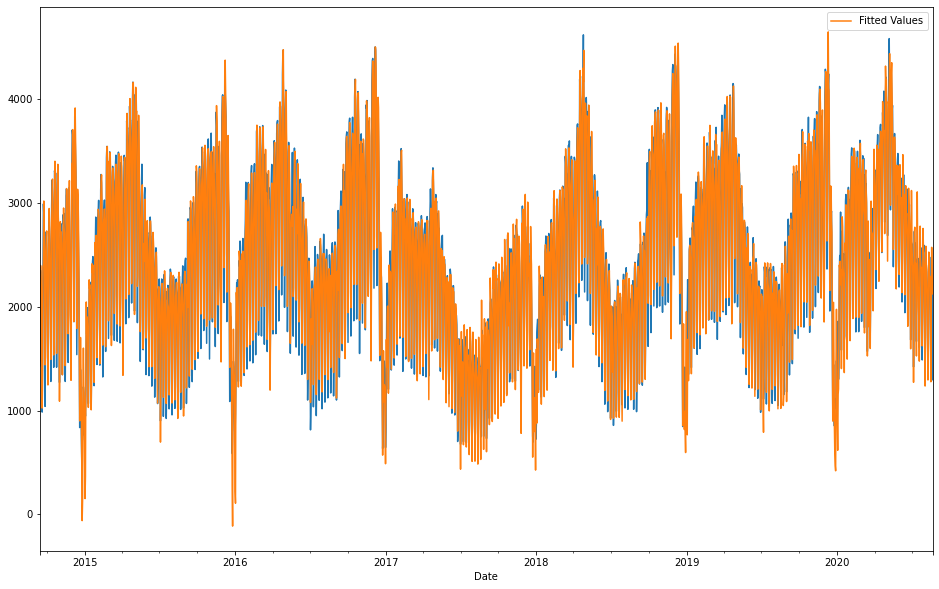

In [191]:
es_fit1 = ExponentialSmoothing(df1, trend='add', seasonal='add').fit()
ax = df1.plot(figsize=(16,10))
es_fit1.fittedvalues.rename('Fitted Values').plot(ax=ax, legend=True)
mean_absolute_percentage_error(df1, es_fit1.fittedvalues);

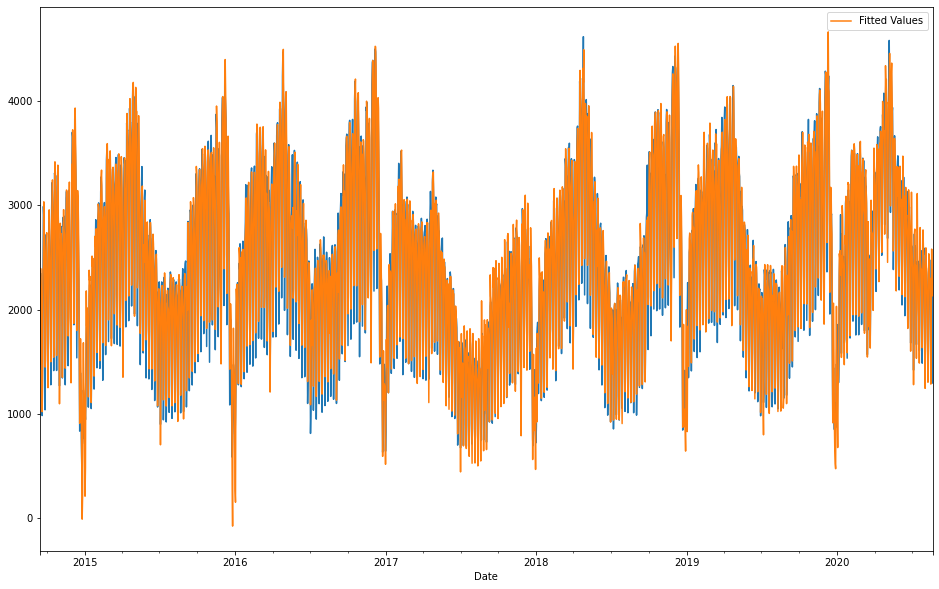

In [192]:
es_fit2 = ExponentialSmoothing(df1, trend='mul', seasonal='add').fit()
ax = df1.plot(figsize=(16,10))
es_fit2.fittedvalues.rename('Fitted Values').plot(ax=ax, legend=True)
mean_absolute_percentage_error(df1, es_fit2.fittedvalues);

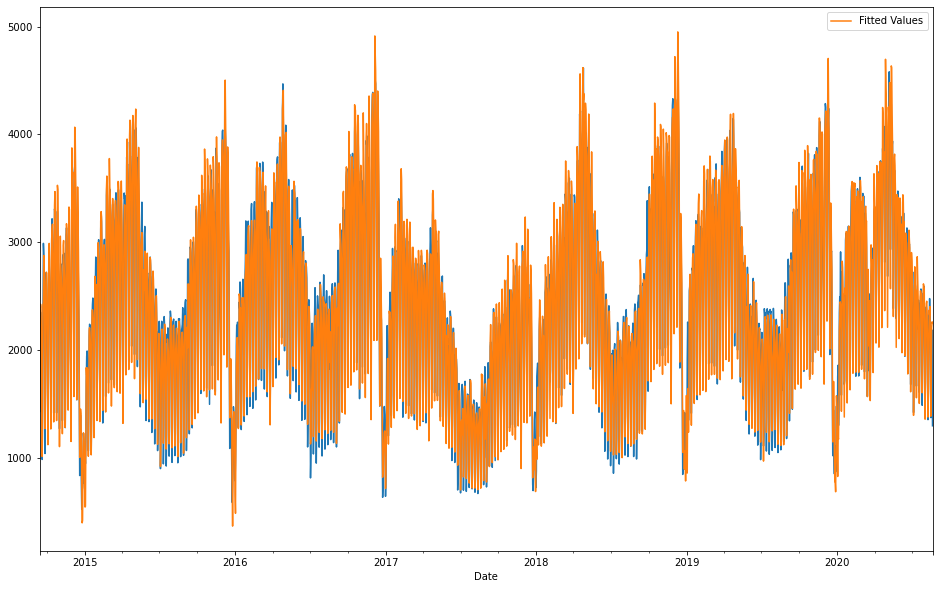

In [193]:
es_fit3 = ExponentialSmoothing(df1, trend='add', seasonal='mul').fit()
ax = df1.plot(figsize=(16,10))
es_fit3.fittedvalues.rename('Fitted Values').plot(ax=ax, legend=True)
mean_absolute_percentage_error(df1, es_fit3.fittedvalues);

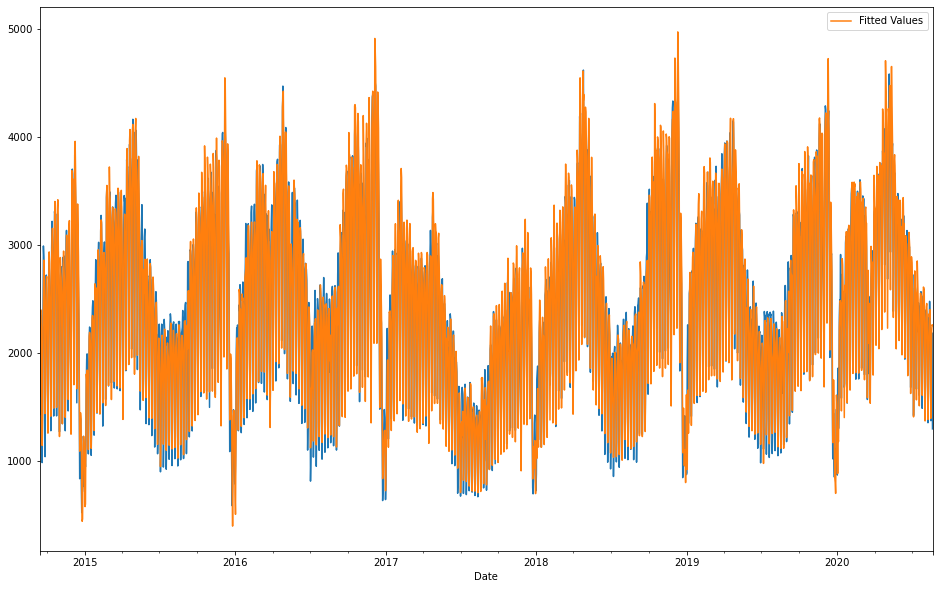

In [194]:
es_fit4 = ExponentialSmoothing(df1, trend='mul', seasonal='mul').fit()
ax = df1.plot(figsize=(16,10))
es_fit4.fittedvalues.rename('Fitted Values').plot(ax=ax, legend=True)
mean_absolute_percentage_error(df1, es_fit4.fittedvalues);

# We get smallest error for trend additive and seasonal multiplicative, so let's forecast values for train and test data

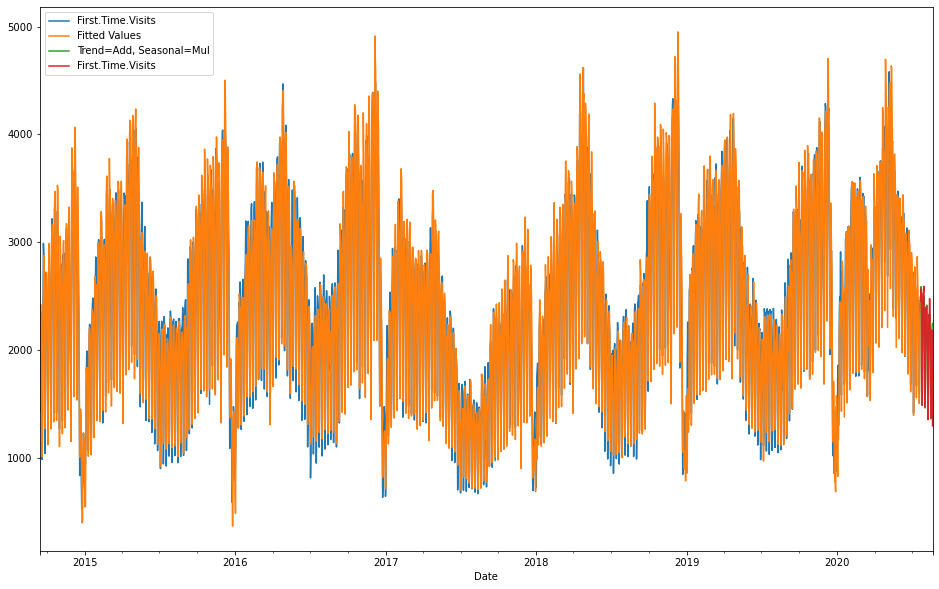

In [195]:
es_fit5 = ExponentialSmoothing(train, trend='add', seasonal='mul').fit()
ax = train.plot(figsize=(16,10), legend=True)
es_fit5.fittedvalues.rename('Fitted Values').plot(ax=ax, legend=True)
es_fcast1 = es_fit5.forecast(len(test)).rename('Trend=Add, Seasonal=Mul')
es_fcast1.plot(ax=ax, legend=True)
test.plot(ax=ax, legend=True);

In [196]:
mean_absolute_percentage_error(train, es_fit5.fittedvalues)

0.06667185862329235

In [157]:
mean_absolute_percentage_error(test, es_fcast1)

0.057614432573351505

<AxesSubplot:xlabel='Date'>

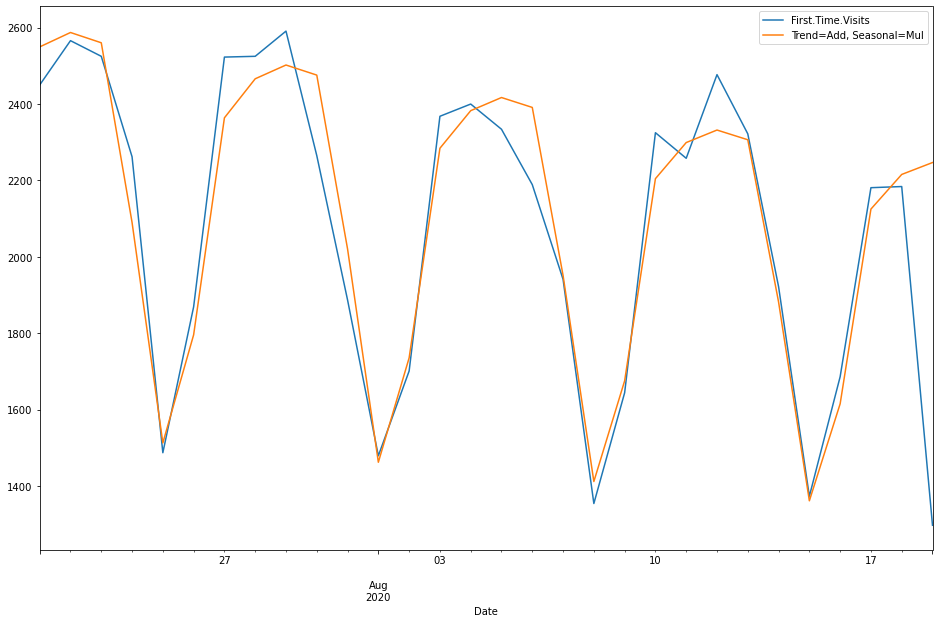

In [197]:
ax = test.plot(figsize=(16,10), legend=True)
es_fcast1.plot(ax=ax, legend=True)

# We can see that error is small and data look pretty accurate, so let's do the prediction for next 30 days

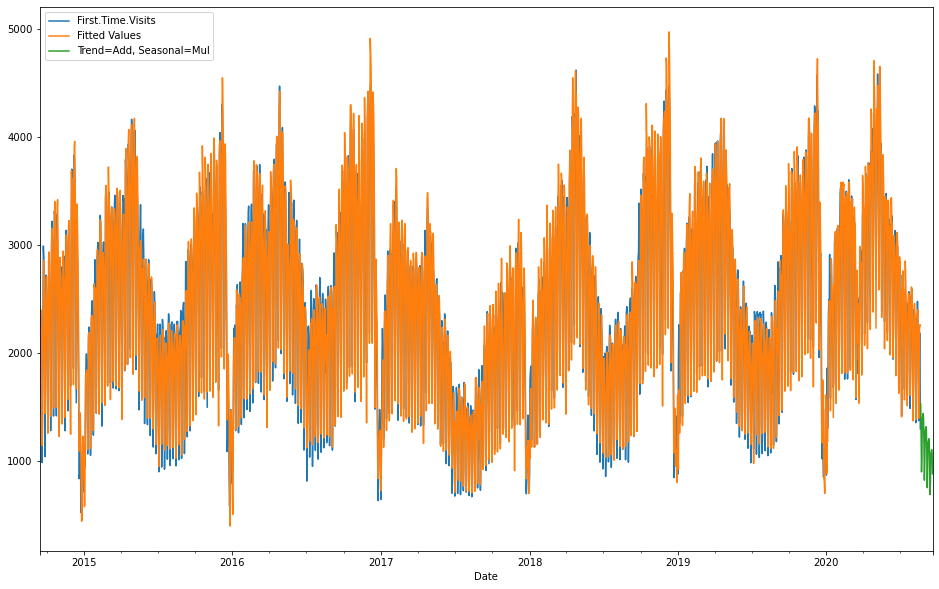

In [198]:
ax = df1.plot(figsize=(16,10), legend=True)
es_fit4.fittedvalues.rename('Fitted Values').plot(ax=ax, legend=True)
es_fcast4 = es_fit4.forecast(30).rename('Trend=Add, Seasonal=Mul')
es_fcast4.plot(ax=ax, legend=True);

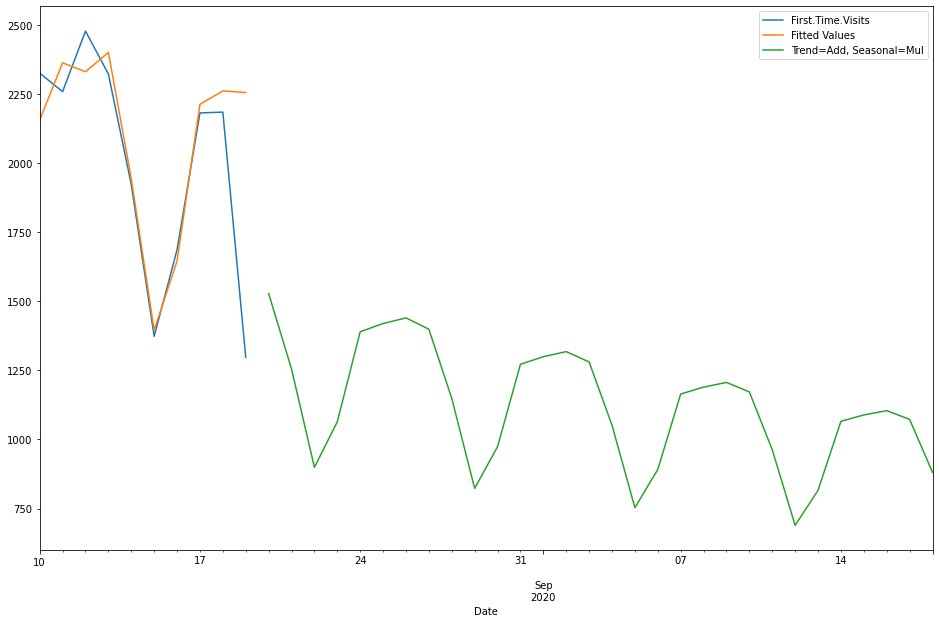

In [199]:
ax = df1[-10:].plot(figsize=(16,10), legend=True)
es_fit4.fittedvalues[-10:].rename('Fitted Values').plot(ax=ax, legend=True)
es_fcast4 = es_fit4.forecast(30).rename('Trend=Add, Seasonal=Mul')
es_fcast4.plot(ax=ax, legend=True);

# Forecast look accurate and might be used as final result, but good choice is to test another model which is Auto Arima for yearly period and then for weekly

In [110]:
from pmdarima import auto_arima

In [112]:
auto_arima(df1, seasonal=True, m=1, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31477.422, Time=1.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33582.394, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33367.185, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32912.778, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=33580.394, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32326.314, Time=1.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32065.890, Time=1.73 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=31976.509, Time=2.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=31440.096, Time=2.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=32167.269, Time=2.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=31283.934, Time=2.89 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=30005.869, Time=3.68 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=30026.816, Time=3.02 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=29831.668, Time=4.50 sec
 ARIMA(5,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2167
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -14871.741
Date:                Fri, 13 May 2022   AIC                          29759.482
Time:                        10:31:11   BIC                          29804.927
Sample:                             0   HQIC                         29776.101
                               - 2167                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1144      0.022      5.196      0.000       0.071       0.158
ar.L2         -0.8590      0.017    -50.905      0.000      -0.892      -0.826
ar.L3         -0.1991      0.028     -7.132      0.000      -0.254      -0.144
ar.L4         -0.4164      0.018    -23.688      0.000      -0.451      -0.382
ar.L5         -0.6340      0.021    -30.029      0.000      -0.675      -0.593
ma.L1         -0.1826      0.023     -7.813      0.000      -0.228      -0.137
ma.L2          0.5034      0.021     23.966      0.000       0.462       0.545
sigma2       5.36e+04   1344.965     39.853      0.000     5.1e+04    5.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):               214.54
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# We get our Best model:  ARIMA(5,1,2)(0,0,0,0). to create prediction let's use SARIMAX

In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

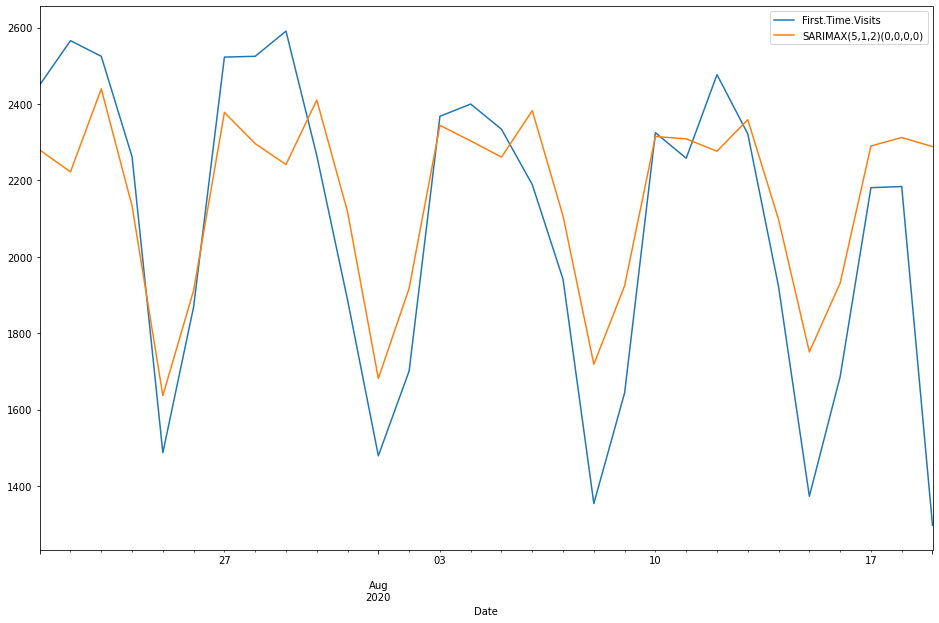

In [200]:
sx1_model = SARIMAX(train, order=(5,1,2), seasonal_order=(0,0,0,0))
results_sx1 = sx1_model.fit()
pred_sx1 = results_sx1.predict(start=start, end=end, dynamic=False).rename('SARIMAX(5,1,2)(0,0,0,0)')
ax = test.plot(legend=True, figsize=(16,10))
pred_sx1.plot(legend=True);

In [123]:
mean_absolute_percentage_error(test, pred_sx1)

0.111863438873039

# We can also check how Arima model might work with daily period of seasonal differecning

In [126]:
auto_arima(df1, seasonal=True, m=7, trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=29214.741, Time=5.49 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33582.394, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29798.887, Time=1.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=31761.991, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33580.394, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=30650.631, Time=4.14 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=9.43 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=7.60 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=31477.422, Time=1.79 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=30574.240, Time=5.03 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=3.48 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=11.79 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=29183.998, Time=4.84 sec
 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=31224.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2167
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 7)   Log Likelihood              -14542.639
Date:                           Fri, 13 May 2022   AIC                          29099.278
Time:                                   10:48:22   BIC                          29139.042
Sample:                                        0   HQIC                         29113.820
                                          - 2167                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7012      0.050     14.083      0.000       0.604       0.799
ma.L1         -0.8093      0.054    -14.887      0.000      -0.916      -0.703
ma.L2         -0.0311      0.026     -1.203      0.229      -0.082       0.020
ar.S.L7        1.0000   4.24e-05   2.36e+04      0.000       1.000       1.000
ma.S.L7       -0.6517      0.020    -33.367      0.000      -0.690      -0.613
ma.S.L14      -0.2570      0.019    -13.585      0.000      -0.294      -0.220
sigma2      4.138e+04    972.225     42.564      0.000    3.95e+04    4.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   7.45   Jarque-Bera (JB):               487.93
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

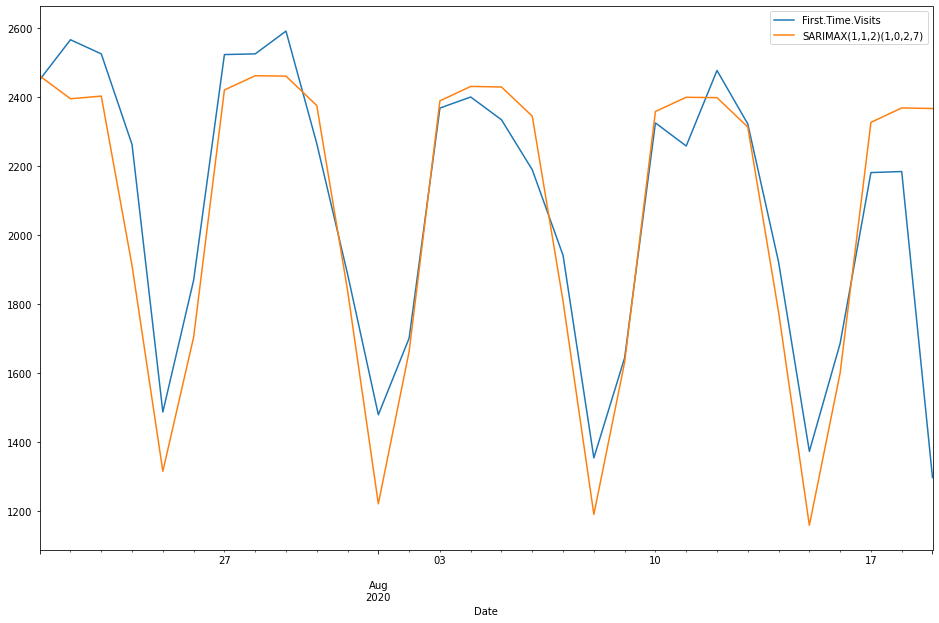

In [201]:
sx2_model = SARIMAX(train, order=(1,1,2), seasonal_order=(1,0,2,7))
results_sx2 = sx2_model.fit()
pred_sx2 = results_sx2.predict(start=start, end=end, dynamic=False).rename('SARIMAX(1,1,2)(1,0,2,7)')
ax = test.plot(legend=True, figsize=(16,10))
pred_sx2.plot(legend=True);

In [128]:
mean_absolute_percentage_error(test, pred_sx2)

0.08556277451975379

# For daily period result is better than for yearly, but error is greater than for Holt-Winters model. Let's compare plots and errors at the end

<AxesSubplot:xlabel='Date'>

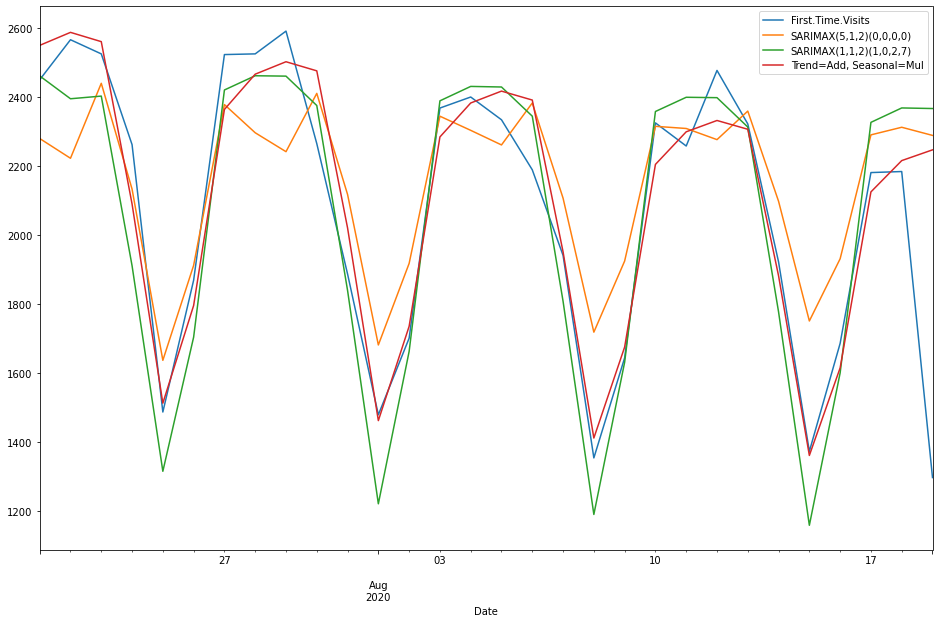

In [203]:
ax = test.plot(legend=True, figsize=(16,10))
pred_sx1.plot(legend=True)
pred_sx2.plot(legend=True)
es_fcast1.plot(ax=ax, legend=True)

In [166]:
print(mean_absolute_percentage_error(test, pred_sx1))
print(mean_absolute_percentage_error(test, pred_sx2))
print(mean_absolute_percentage_error(es_fcast1, test))

0.111863438873039
0.08556277451975379
0.04723090938990136


# Daily Sarimax model gives really close error to my best model, so for comparision let's create forecast for next 30 days

<AxesSubplot:xlabel='Date'>

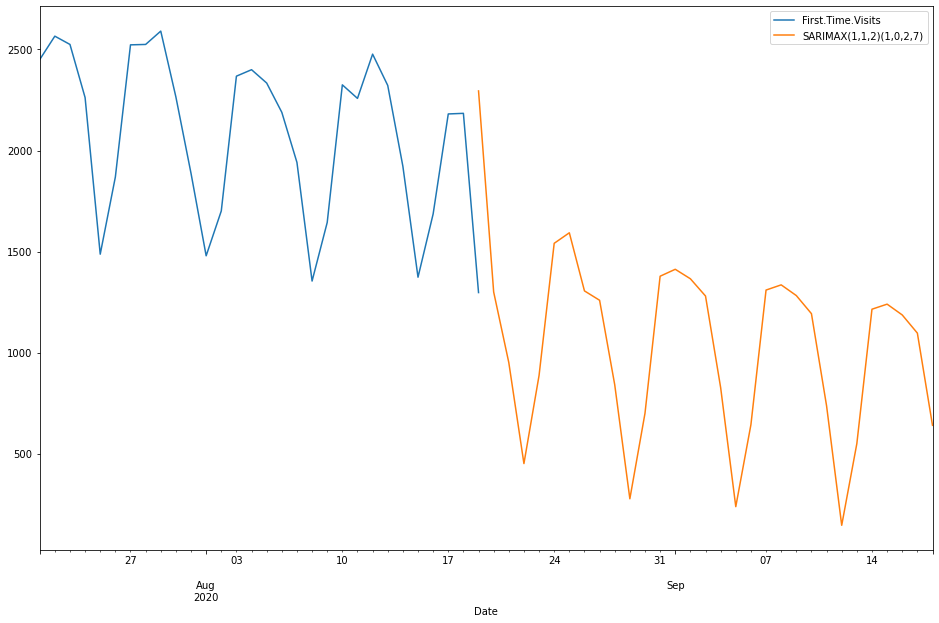

In [202]:
sx3_model = SARIMAX(df1, order=(1,1,2), seasonal_order=(1,0,2,7))
results_sx3 = sx3_model.fit()
pred_sx3 = results_sx3.predict(start=end, end=end+30, dynamic=False).rename('SARIMAX(1,1,2)(1,0,2,7)')
ax = test.plot(legend=True, figsize=(16,10))
pred_sx3.plot(legend=True)

<AxesSubplot:xlabel='Date'>

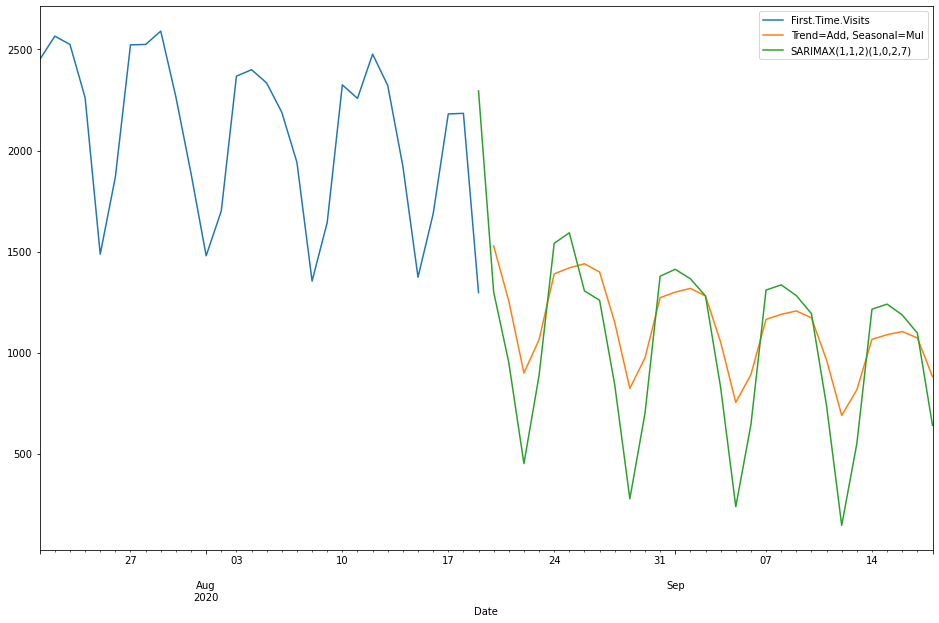

In [204]:
test.plot(legend=True, figsize=(16,10))
es_fcast4.plot(legend=True)
pred_sx3.plot(legend=True)

# We can see that forecast for 2 final models is little bit different, but final model should be Holts-Winters model which gave smallest error